In [1]:
import splat
import wisps
import numpy as np
import matplotlib.pyplot as plt
from wisps import Annotator as an
from wisps import datasets
import pandas as pd
%matplotlib inline

#### Create a Training Set

My training set has wisps stuff and trash i.e things that I know are not bds

But not all of them, I'll just pick 4000 random objects to keep the proportion reasonable? It's a way of scaling my data idk
if this is the right way to go about it 


In [2]:
train_df=datasets['traing_set']

In [3]:
train_df['x']=train_df.spex_chi/train_df.line_chi

#### Choose relevant features

In [4]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2', 'snr1',
       'line_chi', 'x', 'f_test']
label='label'

#### Create a Prediction Set

In [5]:
data=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

In [6]:
#data

In [7]:
data['spt']=data.spt.apply(splat.typeToNum)

In [8]:
##only look at things with snr >3.0
#data=data[(data.snr1>3.0) ]

In [9]:
pred_df=wisps.Annotator.reformat_table(data[features]).applymap(np.float)

#### Apply logarithms to features that might be problematic features

In [10]:
prblm_feats=['line_chi', 'spex_chi', 'H_2O-2/J-Cont', 'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H-cont/H_2O-1', 'snr2', 'snr1', 'x']
pred_df[prblm_feats]=pred_df[prblm_feats].applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
train_df[prblm_feats]=train_df[prblm_feats].applymap(np.float).applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)

#### Rename the class only make 2 classes: brown dwarf and not brown dwarf

In [11]:
def make_label_binary(labl):
    ##only two labels
    if labl >0.:
        return 1.
    else:
        return 0.

In [12]:
train_df['label']=train_df['label'].apply(make_label_binary)
#pred_df['label']=pred_df['label'].apply(make_label_binary)

#### Scale the data to avoid weird stuff 

In [13]:
#pred_df

In [14]:
#scale the data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
#train_set=train_df[features]

X_train, X_test, y_train, y_test = train_test_split(train_df[features].values, train_df[label].values, test_size=0.5,  random_state=123456) ###grammar  

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#scale the data set to predict for 
pred_set=scaler.transform(pred_df[features].replace(-np.inf, np.nan).replace(np.inf, np.nan).replace(np.nan,  -999999.9).values)

#cleanup
X_train.shape

(17027, 16)

In [15]:
from sklearn.ensemble import RandomForestClassifier



def train_model(nestimators=100, random_state=123456):
    """
    trains the model given different parameters
    """
    rf = RandomForestClassifier(n_estimators=nestimators, oob_score=True, random_state=random_state)
    rf.fit(X_train, y_train)
    
    return rf

rf=train_model(nestimators=10000, random_state=123456)

In [16]:
np.isnan(X_test).any(), np.isinf(X_test).any()

(False, False)

accuracy score 0.9868451961475218


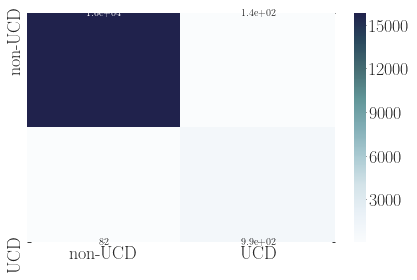

In [17]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
pred_labels = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, pred_labels)

print ('accuracy score {}'.format(model_accuracy))
classes=['non-UCD', 'UCD']
cm = pd.DataFrame(confusion_matrix(y_test, pred_labels), 
                  columns=classes, index=classes)

sns.heatmap(cm, annot=True, cmap=wisps.MYCOLORMAP)

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/confusion_matrix.pdf')

In [18]:
22

22

In [19]:
from sklearn import preprocessing

#def plot_histogram(index):
#    fig, ax=plt.subplots()
#    #plt.xscale('log')
#    plt.yscale('log')
#    plt.hist(pred_set[:, index], bins=50)
    
#for index in np.arange(0, 13): plot_histogram(index)


In [20]:
labels=rf.predict(pred_set)

In [21]:
#np.where(labels==1.)

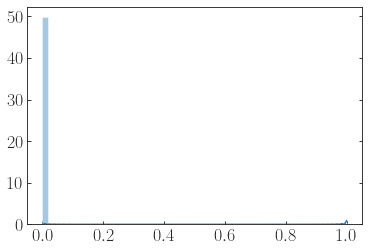

In [22]:
sns.distplot(labels)

In [23]:
len(data[(labels==1)& (data.f_test<0.4)])

285

In [24]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [26]:
data['grism_id']=data.grism_id.apply(lambda x: x.lower().strip())

In [27]:
cands['grism_id']=cands.grism_id.apply(lambda x: x.lower().strip())

In [28]:
tru_p=len(data[(data.grism_id.isin(cands.grism_id.values)) & (labels==1)])
tru_p

109

In [ ]:
490

In [29]:
len((data[(labels==1)])), len(data)

(490, 110930)

In [30]:
(len(data[labels==1])-tru_p)/len(data[labels==1])

0.7775510204081633

In [31]:
(data[(labels==1)]).to_pickle(wisps.LIBRARIES+'/labelled_by_rf.pkl')

In [32]:
#(data[(labels==1)])

In [33]:
import pickle

In [34]:
#save the random forest
output_file=wisps.OUTPUT_FILES+'/random_forest_classifier.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(rf,file)

In [35]:
#save the random forest
output_file2=wisps.OUTPUT_FILES+'/min_max_scaler.pkl'
with open(output_file2, 'wb') as file:
    pickle.dump(scaler,file)